# Estudio comparativo de algoritmos de ascenso de gradiente en un problema de k-armed bandit

*Description:* El experimento compara el rendimiento de algoritmos de ascenso de gradiente en un problema de k-armed bandit.
Se generan gráficas de recompensas promedio para cada algoritmo.

    Author: María Castillo Blaya, Juan José López Quiñonero
    Email: m.castilloblaya@um.es jjose.lopez@um.es
    Date: 2025/06/21

This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.

For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html


## Preparación del entorno


Descargamos el repositorio

In [1]:
!git clone https://github.com/JuanjoLQ/k_brazos_CBLQ.git
!cd k_brazos_CBLQ/

Cloning into 'k_brazos_CBLQ'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 30 (delta 4), reused 30 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (30/30), 2.92 MiB | 10.55 MiB/s, done.
Resolving deltas: 100% (4/4), done.


Importamos todas las clases y funciones que iremos utilizando a lo largo del notebook.

In [2]:
import sys

# Añadir los directorio fuentes al path de Python
sys.path.append('/content/k_brazos_CBLQ')
sys.path.append('/content/k_brazos_CBLQ/src')


# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
from typing import List

from algorithms import Algorithm, Softmax, GradientBandit
from arms import ArmNormal, ArmBinomial, ArmBernoulli, Bandit
from plotting import plot_average_rewards, plot_optimal_selections, plot_arm_statistics, plot_regret


['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/usr/local/lib/python3.11/dist-packages/setuptools/_vendor', '/root/.ipython', '/content/k_brazos_CBLQ', '/content/k_brazos_CBLQ/src']


## Experimento

Cada algoritmo se evalúa en un entorno de **k-armed bandit** durante un número determinado de pasos de tiempo y ejecuciones repetidas. El objetivo es comparar su rendimiento en términos de **recompensa promedio acumulada** a lo largo del tiempo.

### Procedimiento

1. Se define un problema de bandido con **k brazos**, donde cada brazo tiene una distribución de recompensa fija pero desconocida.
2. Se seleccionan **dos algoritmos de ascenso por gradiente**, cada uno configurado con diferentes valores de hiperparámetros.
3. Cada algoritmo se ejecuta durante **T pasos de tiempo** (por ejemplo, 1000 pasos), en los que va actualizando su política con base en las recompensas observadas.
4. Para asegurar la validez estadística, se repite este proceso **N veces** (por ejemplo, 500 ejecuciones independientes por algoritmo).
5. En cada paso de tiempo `t`, se calcula la **recompensa promedio** como el promedio de las recompensas obtenidas en ese paso `t` a lo largo de las `N` ejecuciones.

### Objetivo

Este enfoque permite observar:
- **La evolución de cada política** en el tiempo.
- **La estabilidad y convergencia** de las recompensas.
- **El impacto de los hiperparámetros** en el rendimiento de los algoritmos.

Al final, se obtienen curvas de recompensa promedio que permiten comparar el rendimiento relativo de los algoritmos en condiciones controladas y repetibles.


In [3]:

def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    optimal_arm = bandit.optimal_arm  # Necesario para calcular el porcentaje de selecciones óptimas.

    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.

    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.

    regret_accumulated = np.zeros((len(algorithms), steps)) # inicializamos el rechazo acumulado para cada algoritmo
    arm_stats = [None] * len(algorithms)  # Inicializamos para almacenar al final

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        total_rewards_per_algo = np.zeros(len(algorithms)) # Acumulador de recompensas por algoritmo. Necesario para calcular el promedio.
        optimal_reward = bandit.get_expected_value(optimal_arm) # Valor esperado del brazo óptimo, se calcula una vez.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm() # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.

                rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.

                # Calcular regret acumulado
                if step == 0:
                    regret_accumulated[idx, step] = optimal_reward - current_bandit.get_expected_value(chosen_arm)  # Primera iteración
                else:
                    regret_accumulated[idx, step] = regret_accumulated[idx, step-1] + (optimal_reward - current_bandit.get_expected_value(chosen_arm))


                #TODO: modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                if chosen_arm == optimal_arm:
                  optimal_selections[idx, step] += 1  # Contamos si seleccionó el óptimo


        for idx, algo in enumerate(algorithms):
            if arm_stats[idx] is None:
                arm_stats[idx] = {
                    "mean_rewards": algo.values.copy(),
                    "selection_counts": algo.counts.copy(),
                    "optimal_arm": optimal_arm
                }



    rewards /= runs

    # TODO: calcular el porcentaje de selecciones óptimas y almacenar en optimal_selections
    optimal_selections /= runs  # Promediamos las selecciones óptimas sobre todas las ejecuciones

    return rewards, optimal_selections, regret_accumulated, arm_stats


## Ejecución del Experimento y Visualización de Resultados

El experimento se realiza con un **bandido de 10 brazos**, cuyas recompensas siguen una **distribución normal** con desviación estándar igual a 1.

- Se ejecutan **500 simulaciones** de **1000 pasos** cada una.
- Se comparan dos algoritmos: **Softmax** y **Gradient Bandit**.
- Para **Softmax** se evalúan valores de **τ = 0.1, 0.5, 1**.
- Para **Gradient Bandit** se prueban **α = 0.1, 0.4, 0.7**.

En cada paso se calcula la **recompensa promedio**, promediando los resultados sobre las 500 ejecuciones.


Evaluando métodos de ascenso del gradiente con brazos Bernoulli...
Bandit with 10 arms: ArmBernoulli(p=0.59), ArmBernoulli(p=0.90), ArmBernoulli(p=0.89), ArmBernoulli(p=0.82), ArmBernoulli(p=0.04), ArmBernoulli(p=0.69), ArmBernoulli(p=0.38), ArmBernoulli(p=0.52), ArmBernoulli(p=0.66), ArmBernoulli(p=0.19)
Optimal arm: 2 with expected reward=0.897713727909418

Resultados para Bernoulli:


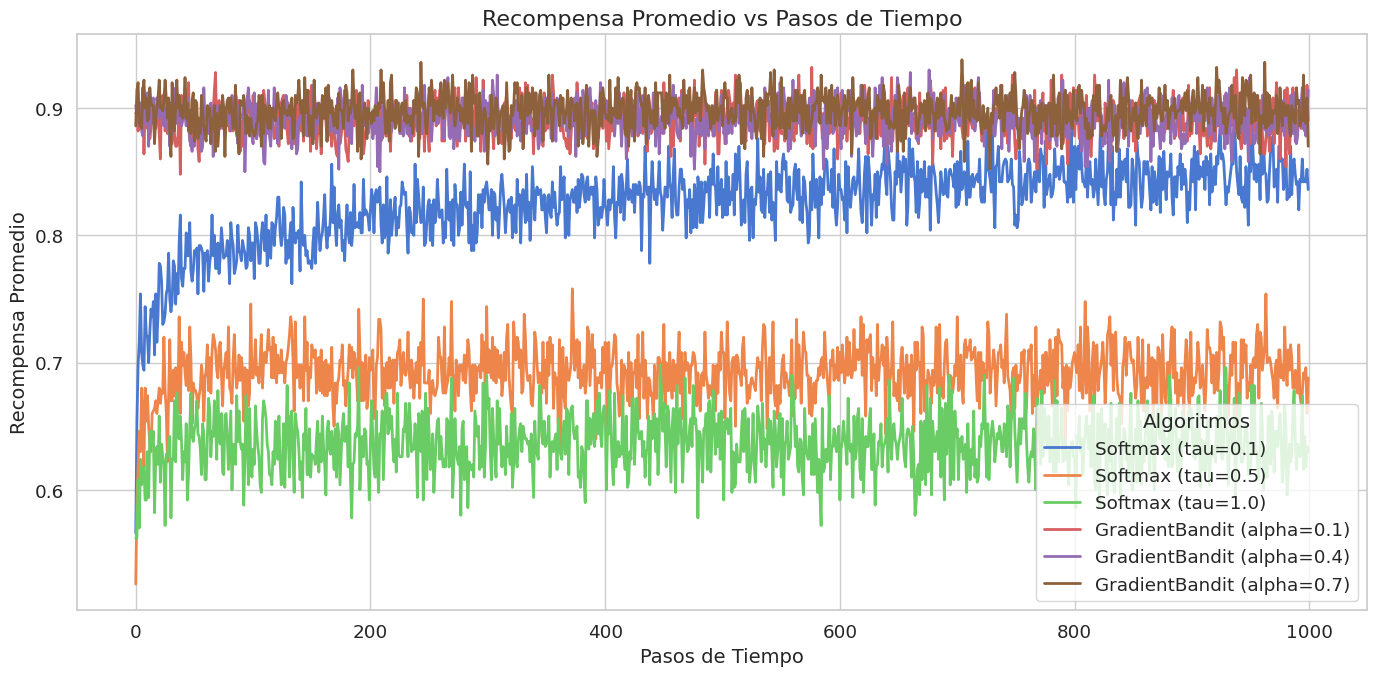

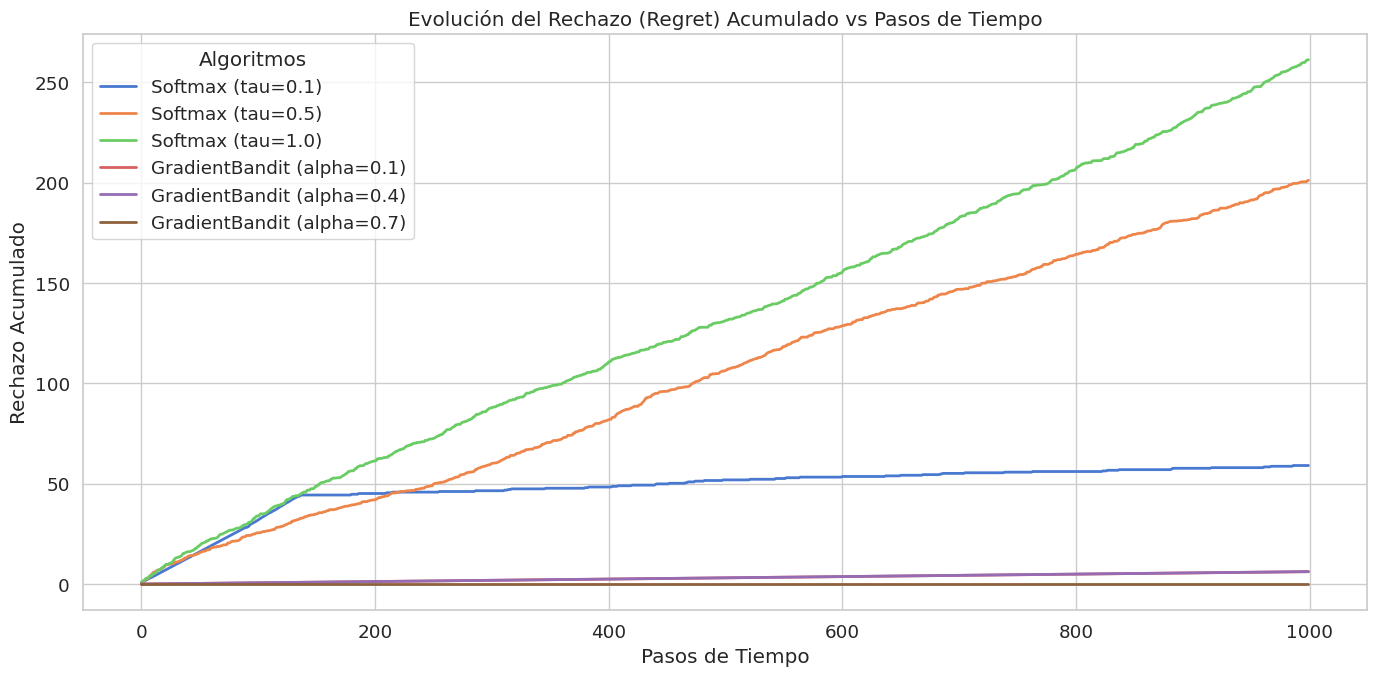


Evaluando métodos de ascenso del gradiente con brazos Binomial...
Bandit with 10 arms: ArmBinomial(n=10, p=0.77), ArmBinomial(n=10, p=0.87), ArmBinomial(n=10, p=0.04), ArmBinomial(n=10, p=0.10), ArmBinomial(n=10, p=0.19), ArmBinomial(n=10, p=0.39), ArmBinomial(n=10, p=0.82), ArmBinomial(n=10, p=0.46), ArmBinomial(n=10, p=0.84), ArmBinomial(n=10, p=0.50)
Optimal arm: 2 with expected reward=8.65383395191915

Resultados para Binomial:


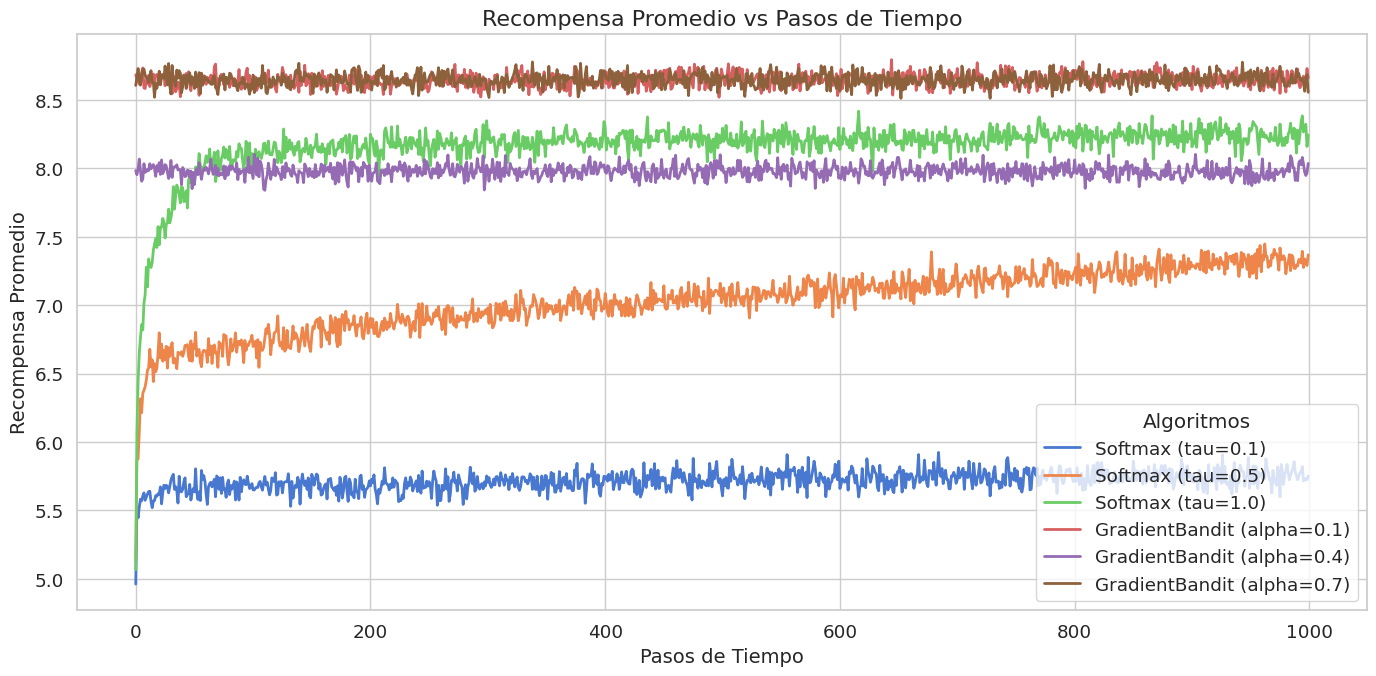

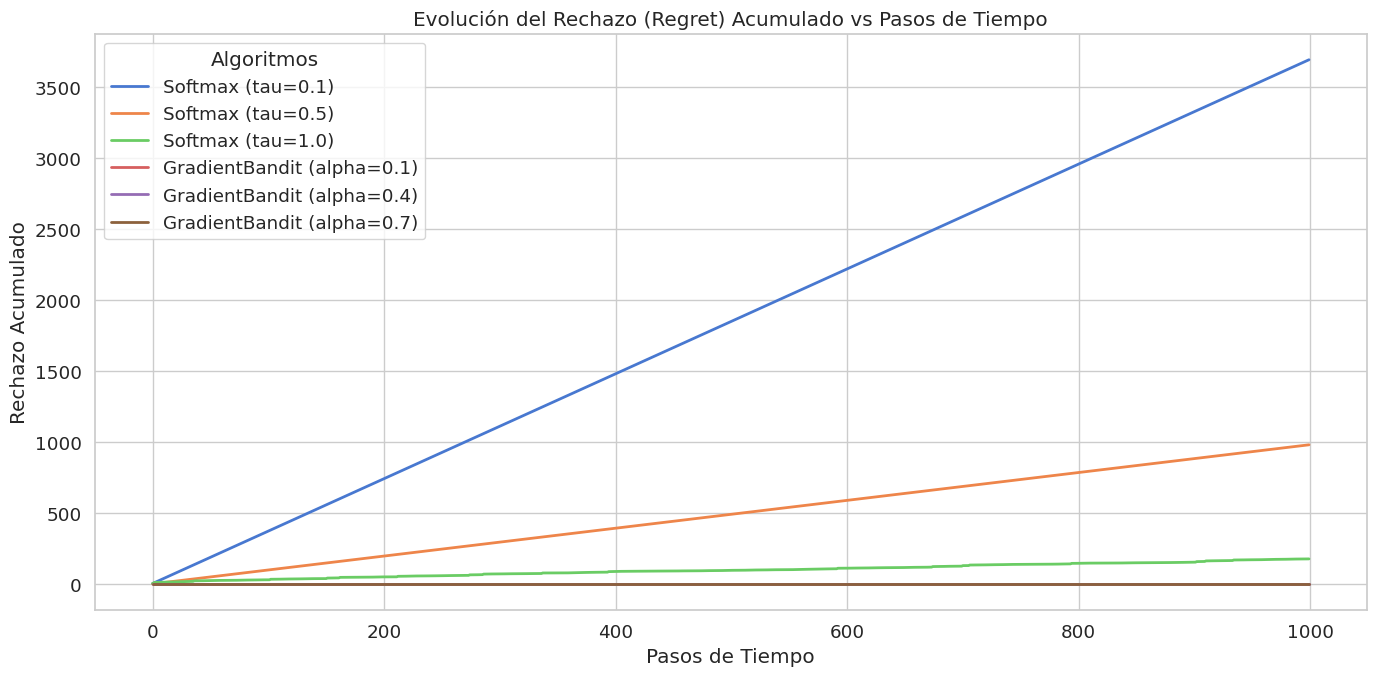


Evaluando métodos de ascenso del gradiente con brazos Normal...
Bandit with 10 arms: ArmNormal(mu=1.39, sigma=1.0), ArmNormal(mu=2.73, sigma=1.0), ArmNormal(mu=1.91, sigma=1.0), ArmNormal(mu=4.48, sigma=1.0), ArmNormal(mu=5.13, sigma=1.0), ArmNormal(mu=5.46, sigma=1.0), ArmNormal(mu=7.91, sigma=1.0), ArmNormal(mu=8.79, sigma=1.0), ArmNormal(mu=8.35, sigma=1.0), ArmNormal(mu=8.56, sigma=1.0)
Optimal arm: 8 with expected reward=8.79

Resultados para Normal:


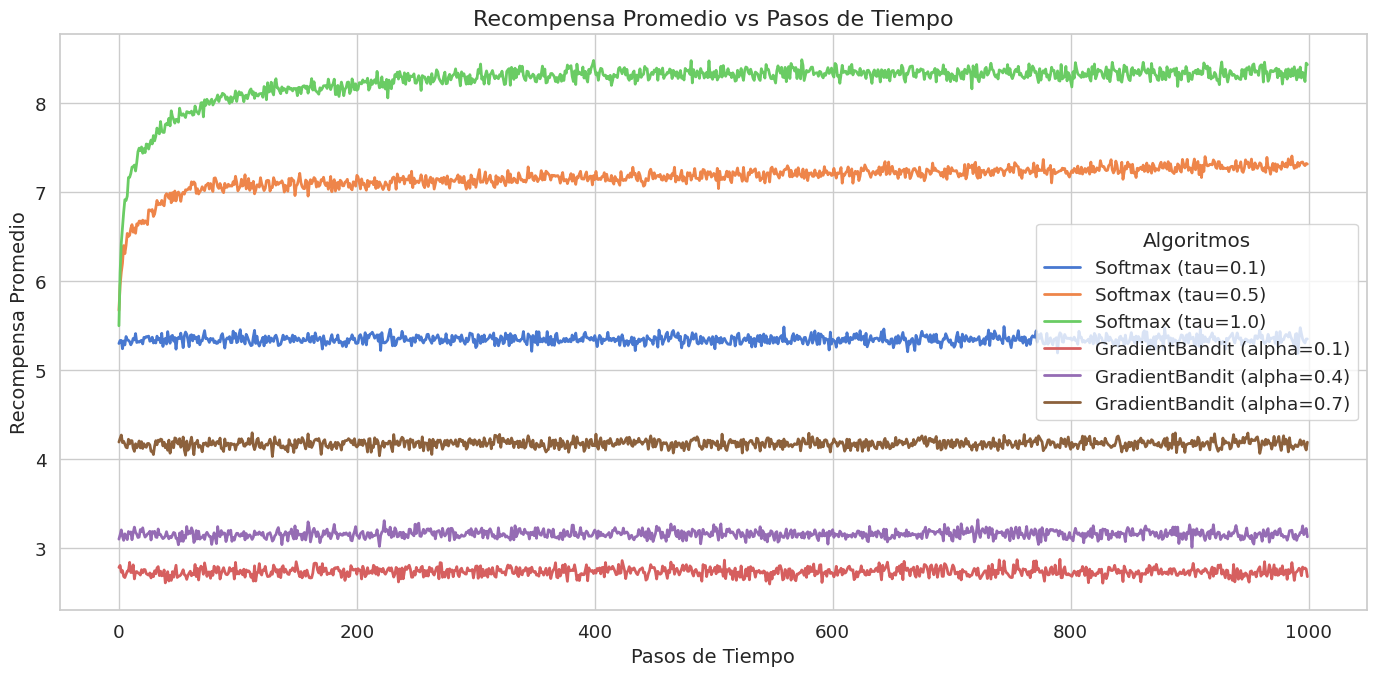

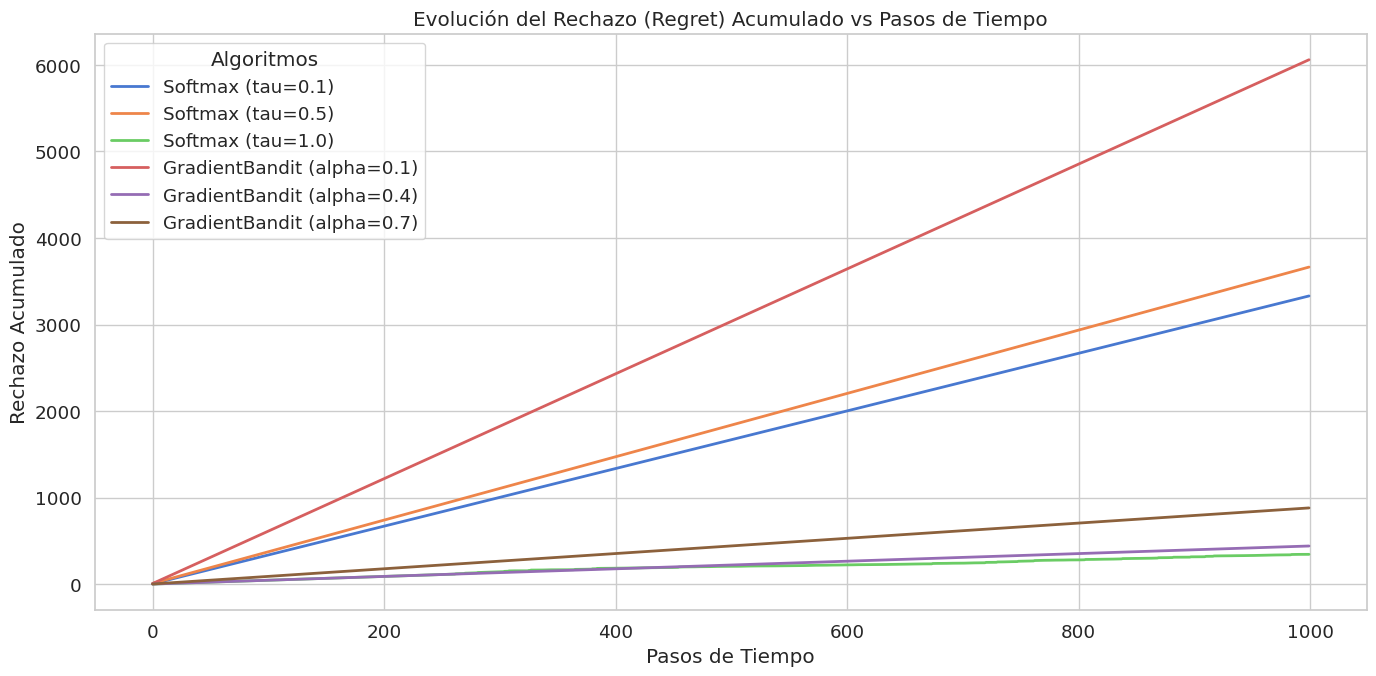

In [4]:
# Parámetros del experimento
seed = 20
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Tipos de brazos que se van a utilizar en el experimento
arm_types = {
    'Bernoulli': ArmBernoulli,
    'Binomial': ArmBinomial,
    'Normal': ArmNormal
}

# Definir los hiperparámetros a comparar para cada algoritmo Softmax y GradientBandit
softmax_configs = [0.1, 0.5, 1.0]  # Temperaturas τ para Softmax
gradient_bandit_configs = [0.1, 0.4, 0.7]  # Tasas de aprendizaje α para GradientBandit

# Definir los algoritmos a comparar en la familia de ascenso del gradiente con diferentes configuraciones
algorithms = []

# Añadir Softmax con diferentes temperaturas τ
for tau in softmax_configs:
    algorithms.append(Softmax(k=k, tau=tau))

# Añadir GradientBandit con diferentes tasas de aprendizaje α
for alpha in gradient_bandit_configs:
    algorithms.append(GradientBandit(k=k, alpha=alpha))

# Bucle para evaluar cada tipo de brazo con los algoritmos definidos
for arm_name, ArmClass in arm_types.items():
    print(f"\nEvaluando métodos de ascenso del gradiente con brazos {arm_name}...")

    # Creación del bandit con el tipo de brazo correspondiente
    bandit = Bandit(arms=ArmClass.generate_arms(k))
    print(bandit)

    # Obtener el brazo óptimo y su recompensa esperada
    optimal_arm = bandit.optimal_arm
    print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

    # Ejecutar el experimento y obtener las recompensas promedio, selecciones óptimas, regret acumulado y estadísticas de brazos
    rewards, optimal_selections, regret_accumulated, arm_stats = run_experiment(bandit, algorithms, steps, runs)

    # Graficar los resultados específicos para este tipo de brazo
    print(f"\nResultados para {arm_name}:")
    plot_average_rewards(steps, rewards, algorithms)
    plot_regret(steps, regret_accumulated, algorithms)


### Análisis detallado de las imágenes – Métodos de Ascenso del Gradiente (Softmax y Gradient Bandit)

Los gráficos analizan el comportamiento de los métodos **Softmax** y **Gradient Bandit** en un problema de **k-armed bandit** con distribuciones: **Bernoulli**, **Binomial** y **Normal**.

---

## 1. Recompensa Promedio vs Pasos de Tiempo

### Distribución Bernoulli
- **Softmax (τ=0.1)**: Mejor rendimiento dentro de Softmax, converge rápido.
- **Softmax (τ=0.5)**: Comportamiento intermedio.
- **Softmax (τ=1.0)**: Peor desempeño, mucha exploración.
- **Gradient Bandit (α=0.1, 0.7)**: Muy buen rendimiento, converge al óptimo rápidamente.

**Gradient Bandit** supera claramente a **Softmax** en esta distribución.

### Distribución Binomial
- **Softmax (τ=1.0)**: Mejor recompensa promedio, exploración efectiva.
- **Softmax (τ=0.5)**: Desempeño intermedio.
- **Softmax (τ=0.1)**: Peor resultado por falta de exploración.
- **Gradient Bandit (α=0.1, 0.4, 0.7)**: Todos convergen rápido y de forma estable.

**Gradient Bandit** vuelve a ser superior.

### Distribución Normal
- **Softmax (τ=1.0)**: Mejor resultado, rápido y estable.
- **Softmax (τ=0.5)**: Aceptable.
- **Softmax (τ=0.1)**: Peor caso, atrapado en decisiones subóptimas.
- **Gradient Bandit (α=0.4)**: Única configuración que se comporta bien.
- **Gradient Bandit (α=0.1, 0.7)**: Bajo rendimiento.

**Softmax (τ=1.0)** y **Gradient Bandit (α=0.4)** son las mejores opciones.

---

## 2. Regret Acumulado vs Pasos de Tiempo

### Distribución Bernoulli
- **Gradient Bandit (todos los α)**: Menor regret acumulado.
- **Softmax (τ=0.1)**: Aceptable, pero peor que Gradient Bandit.
- **Softmax (τ=0.5, 1.0)**: Mayor regret.

### Distribución Binomial
- **Gradient Bandit (todos los α)**: Regret muy bajo.
- **Softmax (τ=1.0)**: Buen rendimiento.
- **Softmax (τ=0.5, 0.1)**: Peor comportamiento, especialmente τ=0.1.

### Distribución Normal
- **Softmax (τ=1.0)**: Menor regret, identifica el brazo óptimo.
- **Gradient Bandit (α=0.4)**: También buen desempeño.
- **Gradient Bandit (α=0.1, 0.7)**: Alto regret.
- **Softmax (τ=0.1)**: No encuentra el óptimo.

---

## 3. Interpretación Conjunta

- **Gradient Bandit** funciona muy bien en distribuciones **discretas**.
- **Softmax** es más **versátil**, especialmente eficaz en la distribución **Normal**.
- **Gradient Bandit** es menos sensible a α.
- **Softmax** requiere un ajuste cuidadoso de τ.

---

## Conclusiones Finales

### 1. Exploración vs Explotación
- **Softmax**:
  - τ bajo (0.1): Explotación temprana, útil en Bernoulli.
  - τ alto (1.0): Más exploración, mejor para Normal y Binomial.
- **Gradient Bandit**:
  - Funciona bien en entornos discretos, pero no con todos los α en Normal.

### 2. Hiperparámetros
- **Softmax (τ=1.0)**: Recomendado salvo en Bernoulli.
- **Gradient Bandit (α=0.1, 0.7)**: Eficiente en Bernoulli y Binomial.
- **Gradient Bandit (α=0.4)**: Buena opción general.

### 3. Regret como métrica
- **Gradient Bandit**: Menor regret en Bernoulli y Binomial.
- **Softmax (τ=1.0)**: Mejor en Normal.

### 4. Efecto de la distribución
- **Bernoulli**: Mejor con Gradient Bandit o Softmax (τ=0.1).
- **Binomial**: Gradient Bandit o Softmax (τ=1.0).
- **Normal**: Softmax (τ=1.0).

---

## Conclusión General

**Gradient Bandit** destaca en problemas discretos.  
**Softmax** ofrece mayor adaptabilidad, pero requiere **ajuste fino de τ** para cada tipo de distribución.